In [ ]:
from google.colab import files
files.upload()  # This will prompt you to upload the kaggle.json file

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"saloni020","key":"7d406bb26d4a2e49be5456215e15a05a"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

# Set the file permissions
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download the dataset
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
100% 5.18G/5.20G [00:50<00:00, 203MB/s]
100% 5.20G/5.20G [00:51<00:00, 109MB/s]


In [ ]:
import zipfile

# Unzip the dataset
with zipfile.ZipFile('skin-cancer-mnist-ham10000.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/skin_cancer_dataset')

In [ ]:
dataset_path = '/content/skin_cancer_dataset'

In [ ]:
# NOTEBOOK.
import kagglehub
kmader_skin_cancer_mnist_ham10000_path = kagglehub.dataset_download('kmader/skin-cancer-mnist-ham10000')

print('Data source import complete.')

100%|██████████| 5.20G/5.20G [00:43<00:00, 128MB/s] 

Extracting files...


Data source import complete.


DOWNLOADING PACKAGES

In [ ]:
!pip install plotly

IMPORTING LIBRARIES

In [ ]:
import numpy as np
import pandas as pd

import io
import os
import tensorflow as tf

from PIL import Image
from glob import glob
import itertools

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, BatchNormalization, Dropout, Dense, MaxPool2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from IPython.display import display
#To see the value of multiple statements at once.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
from glob import glob
import pandas as pd

# Adjust base_skin_dir as per your folder structure after unzipping
base_skin_dir = '/content/skin_cancer_dataset'

# Merging images from both folders into a single dictionary
imageid_path_dict = {
    os.path.splitext(os.path.basename(x))[0]: x
    for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))
}

# Lesion type dictionary for labels
lesion_type_dict = {
    'nv': 'Melanocytic nevi (nv)',
    'mel': 'Melanoma (mel)',
    'bkl': 'Benign keratosis-like lesions (bkl)',
    'bcc': 'Basal cell carcinoma (bcc)',
    'akiec': 'Actinic keratoses (akiec)',
    'vasc': 'Vascular lesions (vasc)',
    'df': 'Dermatofibroma (df)'
}

# Mapping integer labels to lesion types
label_mapping = {
    0: 'nv',
    1: 'mel',
    2: 'bkl',
    3: 'bcc',
    4: 'akiec',
    5: 'vasc',
    6: 'df'
}

# Reverse the label mapping for convenience
reverse_label_mapping = {value: key for key, value in label_mapping.items()}

# Loading metadata
data = pd.read_csv('/content/skin_cancer_dataset/HAM10000_metadata.csv')

print(f'Metadata loaded with shape: {data.shape}')
print(f'Image ID Path Dictionary has {len(imageid_path_dict)} entries')

Metadata loaded with shape: (10015, 7)
Image ID Path Dictionary has 10015 entries


In [ ]:
# Now lets see the sample of tile_df to look on newly made columns
data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [ ]:
data.shape

(10015, 7)

In [ ]:
data.describe(exclude=[np.number])

,lesion_id,image_id,dx,dx_type,sex,localization
count,10015,10015,10015,10015,10015,10015
unique,7470,10015,7,4,3,15
top,HAM_0003789,ISIC_0027419,nv,histo,male,back
freq,6,1,6705,5340,5406,2192


In [ ]:
data.isnull().any().sum()

1

# Imputing the Null values and preparing the data

In [ ]:
# Fill null values in 'age' column with the mean and update the DataFrame
data['age'] = data['age'].fillna(int(data['age'].mean()))

# Convert the dtype of 'age' to int32
data['age'] = data['age'].astype('int32')

In [ ]:
# Adding cell_type and image_path columns
data['cell_type'] = data['dx'].map(lesion_type_dict.get)
data['path'] = data['image_id'].map(imageid_path_dict.get)

In [ ]:
# Adding image pixels
data['image_pixel'] = data['path'].map(lambda x: np.asarray(Image.open(x).resize((28,28))))

<ipython-input-16-a4caa57028f1>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_data = data.groupby('dx').apply(lambda df: df.iloc[:2, [9, 7]])
<ipython-input-16-a4caa57028f1>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.imshow(np.squeeze(sample_data['image_pixel'][i]))
<ipython-input-16-a4caa57028f1>:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a va

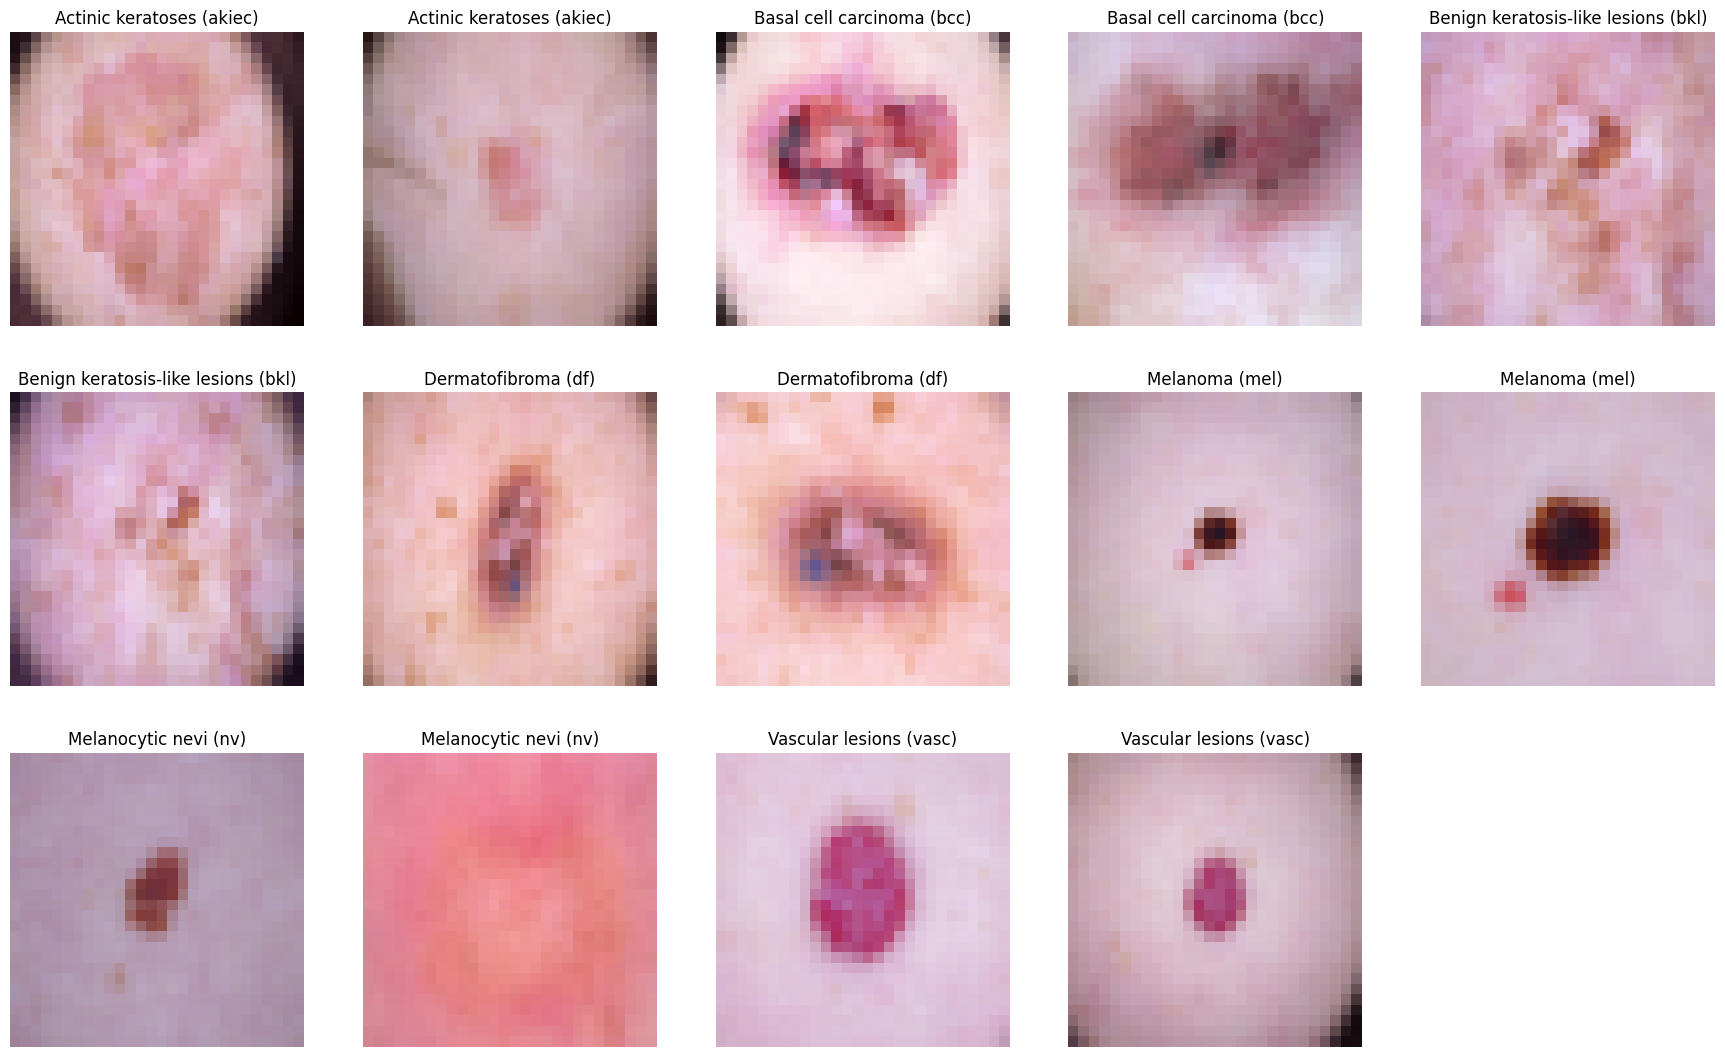

In [ ]:
# Displaying 2 images for each label
sample_data = data.groupby('dx').apply(lambda df: df.iloc[:2, [9, 7]])
plt.figure(figsize=(22, 32))
for i in range(14):
    plt.subplot(7, 5, i + 1)
    plt.imshow(np.squeeze(sample_data['image_pixel'][i]))
    img_label = sample_data['cell_type'][i]
    plt.title(img_label)
    plt.axis("off")
plt.show();

In [ ]:
data['label'] = data['dx'].map(reverse_label_mapping.get)

data = data.sort_values('label')
data = data.reset_index()

In [ ]:
counter = 0
frames = [data]

# Iterate over the list of duplication factors
for i in [4, 4, 11, 17, 45, 52]:
    # Increment the counter to match labels in 'data'
    counter += 1

    # Get indices of rows with the current label
    index = data[data['label'] == counter].index.values

    # Select the subset of DataFrame for the current label
    df_index = data.iloc[min(index):max(index) + 1]

    # Duplicate rows in df_index `i` times and concatenate to frames
    df_index = pd.concat([df_index] * (i + 1), ignore_index=True)  # (i+1) to keep the original rows as well
    frames.append(df_index)

# Concatenate all frames into a single DataFrame
final_data = pd.concat(frames, ignore_index=True)

In [ ]:
final_data = pd.concat(frames)

In [ ]:
print(data.shape)
print(final_data.shape)

(10015, 12)
(45756, 12)


In [ ]:
# ORIGINAL DATA
# Converting image pixel columnm into required format
X_orig = data['image_pixel'].to_numpy()
X_orig = np.stack(X_orig, axis=0)
Y_orig = np.array(data.iloc[:, -1:])
print(X_orig.shape)
print(Y_orig.shape)

(10015, 28, 28, 3)
(10015, 1)


In [ ]:
# AUGMENTED DATA
# Converting image pixel columnm into required format
X_aug = final_data['image_pixel'].to_numpy()
X_aug = np.stack(X_aug, axis=0)
Y_aug = np.array(final_data.iloc[:, -1:])
print(X_aug.shape)
print(Y_aug.shape)

(45756, 28, 28, 3)
(45756, 1)


In [ ]:
def prepare_for_train_test(X, Y):
    # Splitting into train and test set
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

    # Prepare data for training and testing the model
    train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 10,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  shear_range = 0.2,
                                  horizontal_flip = True,
                                  vertical_flip = True,
                                  fill_mode = 'nearest')
    train_datagen.fit(X_train)
    test_datagen = ImageDataGenerator(rescale = 1./255)
    test_datagen.fit(X_test)
    return X_train, X_test, Y_train, Y_test

In [ ]:
# For Original Dataset
X_train_orig, X_test_orig, Y_train_orig, Y_test_orig = prepare_for_train_test(X_orig, Y_orig)

In [ ]:
X_train_aug, X_test_aug, Y_train_aug, Y_test_aug = prepare_for_train_test(X_aug, Y_aug)

In [ ]:
def create_model():
    model = Sequential()
    model.add(Conv2D(16, kernel_size = (3,3), input_shape = (28, 28, 3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2)))

    model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

    model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))
    model.add(Conv2D(128, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

    model.add(Flatten())
    model.add(Dropout(0.1)); model.add(Dense(64, activation = 'relu'))
    model.add(Dropout(0.1)); model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.1)); model.add(Dense(7, activation='softmax'))
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0009, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

    model.compile(loss = 'sparse_categorical_crossentropy',
                  optimizer = optimizer,
                  metrics = ['accuracy'])
    print(model.summary())
    return model;

In [ ]:
model =create_model()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 7, 7, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 7)                   │             231 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 132,583 (517.90 KB)

 Trainable params: 132,583 (517.90 KB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
def train_model(model, X_train, Y_train, EPOCHS=25):
    early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1,
                           mode='auto')
                               #, restore_best_weights=True)

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3,
                              verbose=1, mode='auto')

    history = model.fit(X_train,
                        Y_train,
                        validation_split=0.2,
                        batch_size = 36,
                        epochs = EPOCHS,
                        callbacks = [reduce_lr, early_stop])
    return history

In [ ]:
model2_history = train_model(model, X_train_aug, Y_train_aug, 50)

Epoch 1/50
814/814 ━━━━━━━━━━━━━━━━━━━━ 39s 44ms/step - accuracy: 0.2551 - loss: 2.2387 - val_accuracy: 0.6251 - val_loss: 1.0121 - learning_rate: 9.0000e-04
Epoch 2/50
814/814 ━━━━━━━━━━━━━━━━━━━━ 38s 47ms/step - accuracy: 0.5883 - loss: 1.0654 - val_accuracy: 0.7122 - val_loss: 0.7477 - learning_rate: 9.0000e-04
Epoch 3/50
814/814 ━━━━━━━━━━━━━━━━━━━━ 39s 44ms/step - accuracy: 0.7136 - loss: 0.7469 - val_accuracy: 0.7928 - val_loss: 0.5640 - learning_rate: 9.0000e-04
Epoch 4/50
814/814 ━━━━━━━━━━━━━━━━━━━━ 43s 46ms/step - accuracy: 0.7851 - loss: 0.5678 - val_accuracy: 0.8556 - val_loss: 0.3911 - learning_rate: 9.0000e-04
Epoch 5/50
814/814 ━━━━━━━━━━━━━━━━━━━━ 38s 43ms/step - accuracy: 0.8250 - loss: 0.4657 - val_accuracy: 0.8728 - val_loss: 0.3383 - learning_rate: 9.0000e-04
Epoch 6/50
814/814 ━━━━━━━━━━━━━━━━━━━━ 39s 48ms/step - accuracy: 0.8608 - loss: 0.3675 - val_accuracy: 0.9089 - val_loss: 0.2565 - learning_rate: 9.0000e-04
Epoch 7/50
814/814 ━━━━━━━━━━━━━━━━━━━━ 40s 47ms/ste

In [ ]:
def plot_model_training_curve(history):
    fig = make_subplots(rows=1, cols=2, subplot_titles=['Model Accuracy', 'Model Loss'])
    fig.add_trace(
        go.Scatter(
            y=history.history['accuracy'],
            name='train_acc'),
        row=1, col=1)
    fig.add_trace(
        go.Scatter(
            y=history.history['val_accuracy'],
            name='val_acc'),
        row=1, col=1)
    fig.add_trace(
        go.Scatter(
            y=history.history['loss'],
            name='train_loss'),
        row=1, col=2)
    fig.add_trace(
        go.Scatter(
            y=history.history['val_loss'],
            name='val_loss'),
        row=1, col=2)
    fig.show()

In [ ]:
plot_model_training_curve(model2_history)

In [ ]:
model

<Sequential name=sequential, built=True>

# save model

In [ ]:
model.save('Skin_Cancer.keras')

# save model weights

In [ ]:
# Save only the model weights in HDF5 format
model.save_weights("Skin_Cancer.weights.h5")

In [ ]:
from IPython.display import FileLink
FileLink('Skin_Cancer.weights.h5')

/content/Skin_Cancer.weights.h5

# > ****Checking test accuracy****

In [ ]:
def test_model_accuracy_and_predictions(model, X_test, Y_test, label_mapping):
    # Get test accuracy
    model_acc = model.evaluate(X_test, Y_test, verbose=0)[1]
    print("Test Accuracy: {:.3f}%".format(model_acc * 100))

    # Get true and predicted labels
    y_true = np.array(Y_test)
    y_pred = model.predict(X_test)
    y_pred = np.array([np.argmax(pred) for pred in y_pred])

    # Print classification report
    clr = classification_report(y_true, y_pred, target_names=label_mapping.values())
    print(clr)

In [ ]:
test_model_accuracy_and_predictions(model, X_test_aug, Y_test_aug, label_mapping)

Test Accuracy: 97.727%
286/286 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
              precision    recall  f1-score   support

          nv       0.98      0.87      0.92      1385
         mel       0.94      0.99      0.96      1328
         bkl       0.95      0.99      0.97      1294
         bcc       0.99      1.00      1.00      1325
       akiec       1.00      1.00      1.00      1270
        vasc       1.00      1.00      1.00      1293
          df       1.00      1.00      1.00      1257

    accuracy                           0.98      9152
   macro avg       0.98      0.98      0.98      9152
weighted avg       0.98      0.98      0.98      9152



In [ ]:
def plot_confusion_matrix(Y_test, y_pred, label_mapping):
    # Create confusion matrix
    cm = confusion_matrix(Y_test, y_pred)

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_mapping.values())
    disp.plot(cmap=plt.cm.Blues, values_format="d")
    plt.title("Confusion Matrix")
    plt.show()

286/286 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step


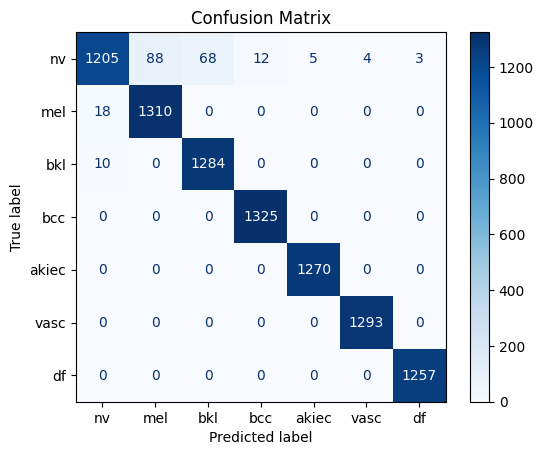

In [ ]:
y_true = np.array(Y_test_aug)
y_pred = model.predict(X_test_aug)
y_pred = np.array([np.argmax(pred) for pred in y_pred])
plot_confusion_matrix(Y_test_aug, y_pred, label_mapping)